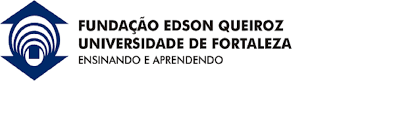

# MINERAÇÃO DE TEXTOS E DA WEB

## ATIVIDADE 02

#### GRUPO 02:
- Agenor Júnior
- Nicole Wirtzbiki
- Torricelli Evangelista

------------------------------------------------------------------------------------------------------------------
INICIO ATIVIDADE 02

- Extração de BOW-unigrama e bigrama dos tweets
- Consulta a bases de conhecimento externas (WordNet, Empath) para definir sinônimos, hiperônimos ou palavras relacionadas com conteúdo ofensivo.
- Vetorização dos tweets usando TF_IDF para os unigramas e bigramas
- Recuperação dos word-embeddings das palavras de cada tweet

### IMPORTANTO PACOTES NECESSÁRIOS

In [1]:
import pandas as pd
import string
import nltk
#nltk.download('punkt')
#nltk.download('average_perceptron_tagger')
#nltk.download('wordnet')
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
language = "english"

from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import WordPunctTokenizer
from nltk.tokenize import TweetTokenizer

from nltk.util import ngrams

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.preprocessing import Binarizer

from contextlib import redirect_stdout
import os
#with redirect_stdout(open(os.devnull, "w")):
    #nltk.download('averaged_perceptron_tagger')

# 1 - Carregando os dados

In [2]:
#leitura para objeto dataframe
tweets = pd.read_csv('/home/nico/Área de Trabalho/MineracaoDadosWeb/entrega 2/olid-training-v1.0.tsv', sep='\t',encoding= 'utf-8')

#conversão da coluna 'id' de inteiro para string
tweets['id'] = tweets['id'].astype('str')

#visualização dos primeiros registros
tweets = tweets[['subtask_c','subtask_b','subtask_a','id','tweet']]
#tweets.head(10)

--------------------------------------------------------------------------------------------------------

# 2 - Normalização

entrada: tweet  |  saída: tweet_normalizado

In [3]:
import re # Importando o módulo "REGEX" para expressões regulares.

In [4]:
def normalizacao_texto(tweet):
    
    #Normalização de todas as palavras para caixa baixa
    tweet = tweet.lower() 
    #remover repetições de "@user"
    #tweet = re.sub('(@user |@user| @user )+',' @user ',tweet)
    
    #remove as menções a usuários de cada tweet
    tweet = re.sub(r'@user', '', tweet, flags=re.MULTILINE)
    #Remoção de repetições seguidas de acentuações
    tweet = re.sub('(!)+','!',tweet)
    tweet = re.sub('(")+','"',tweet)
    tweet = re.sub('(\.)+','.',tweet)
    #Remoção de todas as palavras que começam com "#"
    tweet = re.sub(r"#(\w+)", ' ', tweet, flags=re.MULTILINE)
    #remove as palavras url
    tweet = re.sub(r'url', '', tweet, flags=re.MULTILINE)
    #remove aspas e apóstofres
    tweet = re.sub('[\'"‘’“”…]', '', tweet)
    
    return tweet

tweets['tweet_normalizado'] = tweets['tweet'].apply(normalizacao_texto) 
#tweets[tweets.columns[::-1]].head()    

-------------------------------------------------------------------------------------------------------

# 3 - Tokenização

In [5]:
from nltk.tokenize import TweetTokenizer, sent_tokenize
tweet_tokenizer = TweetTokenizer()

SEPARANDO AS SENTENÇAS
- entrada: tweet_normalizado | saída: tweet_sents

In [6]:
tweets['tweet_sents'] = [sent_tokenize(z) for z in tweets['tweet_normalizado']]
#tweets[tweets.columns[::-1]].head()

SEPARANDO AS PALAVRAS
- entrada: tweet_sents | saída: tweet_tokens


In [7]:
def tokenize(sents):
    tokens = []
    for word in sents:
        tokens.append(nltk.word_tokenize(word)) #separando palavras
    return tokens

tweets['tweet_tokens'] = tweets['tweet_sents'].apply(tokenize)
#tweets[tweets.columns[::-1]].head()

-------------------------------------------------------------------------------------------------------

# 4 - Remoção de Stop Words 
entrada: tweet_tokens | saída: tweet_tokens_sw

In [8]:
def remove_stop_words(sents_list):

    stop_words = set(stopwords.words('english'))
    
    out_list = []
    
    for tokens_list in sents_list:
        tokens = [x for x in tokens_list if not x in stop_words]
        out_list.append(tokens)
        
    return out_list

   
tweets['tweet_tokens_sw'] = tweets['tweet_tokens'].apply(remove_stop_words)
#tweets[tweets.columns[::-1]].head()

-------------------------------------------------------------------------------------------------------

# 5 - POS Tagger

entrada: tweet_tokens_sw | saída: tweet_tagged

In [9]:
def pos_tagger(sent_tokens):
    
    sent_tagged = []
    for token in sent_tokens:
        sent_tagged.append(nltk.pos_tag(token))

    return sent_tagged

tweets['tweet_tagged'] = tweets['tweet_tokens_sw'].apply(pos_tagger)
#tweets[tweets.columns[::-1]].head()

-------------------------------------------------------------------------------------------------------

# 6 - Lemmatização

entrada: tweet_tagged | saída: tweet_lemma

In [10]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

MAPEANDO OS POS-TAGS DO NLTK PARA O FORMATO ACEITO PELO WORDNET LEMMATIZER

In [11]:
tag_dict = {"J": wn.ADJ,
            "N": wn.NOUN,
            "V": wn.VERB,
            "R": wn.ADV}

def extract_wnpostag_from_postag(tag):
    
    #pega a primeira letra da tag
    #segundo parâmetro opcional caso haja chave ausente no dicionário 
    return tag_dict.get(tag[0].upper(), None)

def lemmatize_tupla_word_postag(tupla):
    
    #retorna uma tupla na forma (wordString, posTagString) 
    #como ('guitar', 'NN'), retorna a palavra lematizada.
    tag = extract_wnpostag_from_postag(tupla[1])    
    return lemmatizer.lemmatize(tupla[0], tag) if tag is not None else tupla[0]

LEMMATIZANDO OS TWEETS

In [12]:
def lemmatize_tweets(sent_list):
    
    out_list = []
    for token in sent_list:
        lemmas = [lemmatize_tupla_word_postag(x) for x in token]
        out_list.append(lemmas)

    return out_list

tweets['tweet_lemma'] = tweets['tweet_tagged'].apply(lemmatize_tweets)
#tweets[tweets.columns[::-1]].head()

------------------------------------------------------------------------------------------------------------------

# 7 - Chunking

entrada: tweet_tagged | saída: tweet_chunked

In [13]:
from nltk.chunk import conlltags2tree, tree2conlltags

#with redirect_stdout(open(os.devnull, "w")):
    #nltk.download('maxent_ne_chunker')
    #nltk.download('words')  

In [14]:
from nltk.chunk import conlltags2tree, tree2conlltags

def chunker (tweets_list):
    
    pattern = 'NP: {<DT>?<JJ>*<NN>}'
    pattern1 = 'NP: {<DT>?<JJ>*<NN.*>*}'
    pattern2 = 'NP: {<DT><NN.*><.*>*<NN.*>}'
    
    out_list = []
    
    for lista in tweets_list:
        cp = nltk.RegexpParser(pattern1)
        cs = cp.parse(lista)
        
        iob_tagged = tree2conlltags(cs)
            
        out_list.append(iob_tagged) 
        
    return out_list

tweets['tweet_chunked'] = tweets['tweet_tagged'].apply(chunker)
#tweets[tweets.columns[::-1]].head() 

------------------------------------------------------------------------------------------------------------------

# 8 - NER - Reconhecimento de Entidades

entrada: tweet_tagged | saída: tweet_NER

In [15]:
from nltk.tag import pos_tag
from nltk.chunk import conlltags2tree, tree2conlltags
from pprint import pprint
from nltk.chunk.regexp import ChunkString, ChunkRule, ChinkRule 
from nltk.tree import Tree 
from contextlib import redirect_stdout
import os 

In [16]:
def tweet_NER(tweets_list):
    
    out_list = []
    for tweet in tweets_list:
        out_list.append(nltk.ne_chunk(tweet))
        
    return out_list

tweets['tweet_NER'] = tweets['tweet_tagged'].apply(chunker)
#tweets[tweets.columns[::-1]].head()

### PRODUTOS DA ATIVIDADE 01:

As entregas da atividade 01 são as colunas do Dataframe com os arrays de tweets:

- tweets['tweet_lemma']
- tweets['tweet_chunked']
- tweets['tweet_NER']

------------------------------------------------------------------------------------------------------------------
# INICIO ATIVIDADE 02

- Extração de BOW-unigrama e bigrama dos tweets
- Consulta a bases de conhecimento externas (WordNet, Empath) para definir sinônimos, hiperônimos ou palavras relacionadas com conteúdo ofensivo.
- Vetorização dos tweets usando TF_IDF para os unigramas e bigramas
- Recuperação dos word-embeddings das palavras de cada tweet

### IMPORTANDO MÓDULOS NECESSÁRIOS

In [17]:
#nltk.download ('wordnet')
from nltk.corpus import wordnet as wn
from itertools import chain

# 9 - Extração de BOW Unigrama e Bigrama dos Tweets


In [18]:
def word_grams(words_list, n):
     s = []
     for ngram in ngrams(words_list, n):
         s.append(' '.join(str(i) for i in ngram))
     return s

UNIGRAMAS
* entrada: tweet_tokens_sw | saída: tweet_unigram

In [19]:
def unigramer(sents_list):
    out_list = []
    for sent in sents_list:
        out_list.append(word_grams(sent,1))
    return out_list       
    
tweets['tweet_unigram'] = tweets['tweet_tokens_sw'].apply(unigramer)
tweets[tweets.columns[::-1]].head()

,tweet_unigram,tweet_NER,tweet_chunked,tweet_lemma,tweet_tagged,tweet_tokens_sw,tweet_tokens,tweet_sents,tweet_normalizado,tweet,id,subtask_a,subtask_b,subtask_c
0,"[[ask, native, americans, take, .]]","[[(ask, RB, O), (native, JJ, B-NP), (americans...","[[(ask, RB, O), (native, JJ, B-NP), (americans...","[[ask, native, american, take, .]]","[[(ask, RB), (native, JJ), (americans, NNS), (...","[[ask, native, americans, take, .]]","[[she, should, ask, a, few, native, americans,...",[ she should ask a few native americans what t...,she should ask a few native americans what th...,@USER She should ask a few native Americans wh...,86426,OFF,UNT,NaN
1,"[[go, home, youre, drunk, !], [👊🇺🇸👊]]","[[(go, VB, O), (home, NN, B-NP), (youre, NN, I...","[[(go, VB, O), (home, NN, B-NP), (youre, NN, I...","[[go, home, youre, drunk, !], [👊🇺🇸👊]]","[[(go, VB), (home, NN), (youre, NN), (drunk, N...","[[go, home, youre, drunk, !], [👊🇺🇸👊]]","[[go, home, youre, drunk, !], [👊🇺🇸👊]]","[ go home youre drunk!, 👊🇺🇸👊]",go home youre drunk! 👊🇺🇸👊,@USER @USER Go home you’re drunk!!! @USER #MAG...,90194,OFF,TIN,IND
2,"[[amazon, investigating, chinese, employees, s...","[[(amazon, NN, B-NP), (investigating, VBG, O),...","[[(amazon, NN, B-NP), (investigating, VBG, O),...","[[amazon, investigate, chinese, employee, sell...","[[(amazon, NN), (investigating, VBG), (chinese...","[[amazon, investigating, chinese, employees, s...","[[amazon, is, investigating, chinese, employee...",[amazon is investigating chinese employees who...,amazon is investigating chinese employees who ...,Amazon is investigating Chinese employees who ...,16820,NOT,NaN,NaN
3,"[[someone, shouldvetaken, piece, shit, volcano...","[[(someone, NN, B-NP), (shouldvetaken, VBD, O)...","[[(someone, NN, B-NP), (shouldvetaken, VBD, O)...","[[someone, shouldvetaken, piece, shit, volcano...","[[(someone, NN), (shouldvetaken, VBD), (piece,...","[[someone, shouldvetaken, piece, shit, volcano...","[[someone, shouldvetaken, this, piece, of, shi...",[ someone shouldvetaken this piece of shit to ...,someone shouldvetaken this piece of shit to a...,"@USER Someone should'veTaken"" this piece of sh...",62688,OFF,UNT,NaN
4,"[[obama, wanted, liberals, &, amp, ;, illegals...","[[(obama, RB, O), (wanted, VBD, O), (liberals,...","[[(obama, RB, O), (wanted, VBD, O), (liberals,...","[[obama, want, liberal, &, amp, ;, illegals, m...","[[(obama, RB), (wanted, VBD), (liberals, NNS),...","[[obama, wanted, liberals, &, amp, ;, illegals...","[[obama, wanted, liberals, &, amp, ;, illegals...",[ obama wanted liberals &amp; illegals to mov...,obama wanted liberals &amp; illegals to move...,@USER @USER Obama wanted liberals &amp; illega...,43605,NOT,NaN,NaN


BIGRAMAS
* entrada: tweet_tokens_sw | saída: tweet_bigram

In [20]:
def bigramer(tokens_list):
    out_list = []
    for sent in tokens_list:
        out_list.append(word_grams(sent,2))
    return out_list       
    
tweets['tweet_bigram'] = tweets['tweet_tokens_sw'].apply(bigramer)
#tweets[tweets.columns[::-1]].head()
tweets[['tweet_unigram','tweet_bigram']].head()

,tweet_unigram,tweet_bigram
0,"[[ask, native, americans, take, .]]","[[ask native, native americans, americans take..."
1,"[[go, home, youre, drunk, !], [👊🇺🇸👊]]","[[go home, home youre, youre drunk, drunk !], []]"
2,"[[amazon, investigating, chinese, employees, s...","[[amazon investigating, investigating chinese,..."
3,"[[someone, shouldvetaken, piece, shit, volcano...","[[someone shouldvetaken, shouldvetaken piece, ..."
4,"[[obama, wanted, liberals, &, amp, ;, illegals...","[[obama wanted, wanted liberals, liberals &, &..."


------------------------------------------------------------------------------------------------------------------

# 10 - Uso de bases de conhecimento externas
EXTRAÇÃO E ARMAZENAMENTO DE SINONIMOS

- Consulta à Base lexico-semântica WordNet : WordNet de Princeton (original em Inglês)

In [84]:
def synonimer(tokens_list):
    out_list = []
    synonims = []
    lemmas = []
    for sent in tokens_list:
        for w in sent:
            synonyms = wn.synsets(w)
            lemmas = set(chain.from_iterable([Word.lemma_names() for Word in synonyms]))
            out_list.append([w,lemmas]) #mostra a palavra, e em seguida a lista de sinonimos
        return out_list 


tweets['tweet_sinonimos'] = [synonimer(x) for x in tweets['tweet_lemma']]
print(tweets['tweet_sinonimos'][0]) #imprimindo os sinonimos das palavras do primeiro tweet

[['ask', {'take', 'need', 'require', 'enquire', 'inquire', 'ask', 'necessitate', 'involve', 'demand', 'expect', 'postulate', 'call_for'}], ['native', {'indigen', 'aborigine', 'aboriginal', 'indigene', 'native'}], ['american', {'American', 'American_English', 'American_language'}], ['take', {'look_at', 'train', 'direct', 'claim', 'study', 'necessitate', 'ask', 'consume', 'consider', 'postulate', 'use_up', 'contract', 'take_up', 'call_for', 'hold', 'payoff', 'remove', 'get_hold_of', 'withdraw', 'admit', 'guide', 'choose', 'take', 'take_aim', 'lead', 'occupy', 'bring', 'need', 'exact', 'aim', 'hire', 'involve', 'make', 'subscribe_to', 'film', 'issue', 'convey', 'pick_out', 'accept', 'charter', 'engage', 'take_away', 'pack', 'take_on', 'submit', 'ingest', 'shoot', 'conduct', 'read', 'subscribe', 'demand', 'strike', 'return', 'deal', 'take_in', 'learn', 'acquire', 'adopt', 'drive', 'select', 'require', 'lease', 'contain', 'get', 'fill', 'takings', 'yield', 'carry', 'assume', 'proceeds', 're

In [22]:
tweets[tweets.columns[::-1]].head()

,tweet_sinonimos,tweet_bigram,tweet_unigram,tweet_NER,tweet_chunked,tweet_lemma,tweet_tagged,tweet_tokens_sw,tweet_tokens,tweet_sents,tweet_normalizado,tweet,id,subtask_a,subtask_b,subtask_c
0,"[[ask, {take, need, require, enquire, inquire,...","[[ask native, native americans, americans take...","[[ask, native, americans, take, .]]","[[(ask, RB, O), (native, JJ, B-NP), (americans...","[[(ask, RB, O), (native, JJ, B-NP), (americans...","[[ask, native, american, take, .]]","[[(ask, RB), (native, JJ), (americans, NNS), (...","[[ask, native, americans, take, .]]","[[she, should, ask, a, few, native, americans,...",[ she should ask a few native americans what t...,she should ask a few native americans what th...,@USER She should ask a few native Americans wh...,86426,OFF,UNT,NaN
1,"[[go, {fit, give_way, get_going, spell, give_o...","[[go home, home youre, youre drunk, drunk !], []]","[[go, home, youre, drunk, !], [👊🇺🇸👊]]","[[(go, VB, O), (home, NN, B-NP), (youre, NN, I...","[[(go, VB, O), (home, NN, B-NP), (youre, NN, I...","[[go, home, youre, drunk, !], [👊🇺🇸👊]]","[[(go, VB), (home, NN), (youre, NN), (drunk, N...","[[go, home, youre, drunk, !], [👊🇺🇸👊]]","[[go, home, youre, drunk, !], [👊🇺🇸👊]]","[ go home youre drunk!, 👊🇺🇸👊]",go home youre drunk! 👊🇺🇸👊,@USER @USER Go home you’re drunk!!! @USER #MAG...,90194,OFF,TIN,IND
2,"[[amazon, {Amazon, virago, Amazon_River, amazo...","[[amazon investigating, investigating chinese,...","[[amazon, investigating, chinese, employees, s...","[[(amazon, NN, B-NP), (investigating, VBG, O),...","[[(amazon, NN, B-NP), (investigating, VBG, O),...","[[amazon, investigate, chinese, employee, sell...","[[(amazon, NN), (investigating, VBG), (chinese...","[[amazon, investigating, chinese, employees, s...","[[amazon, is, investigating, chinese, employee...",[amazon is investigating chinese employees who...,amazon is investigating chinese employees who ...,Amazon is investigating Chinese employees who ...,16820,NOT,NaN,NaN
3,"[[someone, {person, somebody, mortal, someone,...","[[someone shouldvetaken, shouldvetaken piece, ...","[[someone, shouldvetaken, piece, shit, volcano...","[[(someone, NN, B-NP), (shouldvetaken, VBD, O)...","[[(someone, NN, B-NP), (shouldvetaken, VBD, O)...","[[someone, shouldvetaken, piece, shit, volcano...","[[(someone, NN), (shouldvetaken, VBD), (piece,...","[[someone, shouldvetaken, piece, shit, volcano...","[[someone, shouldvetaken, this, piece, of, shi...",[ someone shouldvetaken this piece of shit to ...,someone shouldvetaken this piece of shit to a...,"@USER Someone should'veTaken"" this piece of sh...",62688,OFF,UNT,NaN
4,"[[obama, {}], [want, {privation, need, wishing...","[[obama wanted, wanted liberals, liberals &, &...","[[obama, wanted, liberals, &, amp, ;, illegals...","[[(obama, RB, O), (wanted, VBD, O), (liberals,...","[[(obama, RB, O), (wanted, VBD, O), (liberals,...","[[obama, want, liberal, &, amp, ;, illegals, m...","[[(obama, RB), (wanted, VBD), (liberals, NNS),...","[[obama, wanted, liberals, &, amp, ;, illegals...","[[obama, wanted, liberals, &, amp, ;, illegals...",[ obama wanted liberals &amp; illegals to mov...,obama wanted liberals &amp; illegals to move...,@USER @USER Obama wanted liberals &amp; illega...,43605,NOT,NaN,NaN


------------------------------------------------------------------------------------------------------------------

# 11 - Vetorização dos tweets usando TF_IDF para os unigramas e bigramas

In [118]:
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer

### UNIGRAMAS

In [143]:
tokenizador = TweetTokenizer()

cv = TfidfVectorizer(tokenizer = tokenizador.tokenize, ngram_range= (1,1)) #é utilizado o mesmo tokenizador para o processo de vetorização

tweets['vetorizacao_unigram'] = cv.fit_transform(tweets['tweet_normalizado'])
print(tweets['vetorizacao_unigram'][0][:2]) #print dos TF-IDF do primeiro tweet

  (0, 16)	0.08870467774061283
  (0, 9129)	0.11349543948027377
  (0, 16878)	0.17903605688560628
  (0, 11956)	0.18346531530338953
  (0, 16537)	0.2913232818613757
  (0, 16802)	0.2365956376126155
  (0, 18330)	0.2067922590837221
  (0, 1122)	0.3446327079544235
  (0, 11409)	0.481427822236437
  (0, 6678)	0.374284281569373
  (0, 567)	0.12606762847148154
  (0, 1538)	0.35758538129472095
  (0, 15204)	0.25257071905846223
  (0, 15083)	0.1781615846241865
  (1, 19001)	0.2539919127450704
  (1, 19003)	0.2545452189205905
  (1, 19085)	0.7406915555768779
  (1, 0)	0.1271936449800965
  (1, 5629)	0.3441724856846966
  (1, 18826)	0.24342893774691327
  (1, 8284)	0.28404122283166106
  (1, 7469)	0.21794694780123144


In [115]:
tweets[['vetorizacao_unigram']].head() #TF-IDF de cada tweet por unigrama guardado no dataframe

,vetorizacao_unigram
0,"(0, 16)\t0.08870467774061283\n (0, 9129)\t0..."
1,"(0, 16)\t0.08870467774061283\n (0, 9129)\t0..."
2,"(0, 16)\t0.08870467774061283\n (0, 9129)\t0..."
3,"(0, 16)\t0.08870467774061283\n (0, 9129)\t0..."
4,"(0, 16)\t0.08870467774061283\n (0, 9129)\t0..."


In [138]:
# Recuperando unigramas  
vectorizer = CountVectorizer(ngram_range = (1,1)) 
X0 = vectorizer.fit_transform(tweets['tweet_normalizado'])  
features = (vectorizer.get_feature_names()) 

# TOP RANKING features 
sums = tweets['vetorizacao_unigram'].sum(axis = 0) 
data1 = [] 
for col, term in enumerate(features): 
    data1.append( (term, sums[0, col] )) 
ranking = pd.DataFrame(data1, columns = ['Unigrama', 'rank']) 
words = (ranking.sort_values('rank', ascending = False)) 
print ("\n\nWords : \n", words.head(10)) 



Words : 
          Unigrama         rank
11409    oxymoron  6374.104366
6678       funner  4955.523888
1538          bae  4734.430448
1122        apple  4562.937053
16537     uniform  3857.120252
15204  structural  3344.036320
16802       versa  3132.526242
11956     pleases  2429.080775
16878  villifying  2370.437393
15083    stickers  2358.859380


### BIGRAMAS

In [144]:
tokenizador = TweetTokenizer()

cv2 = TfidfVectorizer(tokenizer = tokenizador.tokenize, ngram_range= (2,2))

tweets['vetorizacao_bigram'] = cv2.fit_transform(tweets['tweet_normalizado'])

print(tweets['vetorizacao_unigram'][0][:2]) #print dos TF-IDF do primeiro tweet

  (0, 16)	0.08870467774061283
  (0, 9129)	0.11349543948027377
  (0, 16878)	0.17903605688560628
  (0, 11956)	0.18346531530338953
  (0, 16537)	0.2913232818613757
  (0, 16802)	0.2365956376126155
  (0, 18330)	0.2067922590837221
  (0, 1122)	0.3446327079544235
  (0, 11409)	0.481427822236437
  (0, 6678)	0.374284281569373
  (0, 567)	0.12606762847148154
  (0, 1538)	0.35758538129472095
  (0, 15204)	0.25257071905846223
  (0, 15083)	0.1781615846241865
  (1, 19001)	0.2539919127450704
  (1, 19003)	0.2545452189205905
  (1, 19085)	0.7406915555768779
  (1, 0)	0.1271936449800965
  (1, 5629)	0.3441724856846966
  (1, 18826)	0.24342893774691327
  (1, 8284)	0.28404122283166106
  (1, 7469)	0.21794694780123144


In [132]:
tweets[['vetorizacao_bigram']].head() #TF-IDF de cada tweet por bigrama guardado no dataframe

,vetorizacao_bigram
0,"(0, 59169)\t0.179042155839197\n (0, 108541)..."
1,"(0, 59169)\t0.179042155839197\n (0, 108541)..."
2,"(0, 59169)\t0.179042155839197\n (0, 108541)..."
3,"(0, 59169)\t0.179042155839197\n (0, 108541)..."
4,"(0, 59169)\t0.179042155839197\n (0, 108541)..."


In [139]:
# Recuperando bigramas  
vectorizer = CountVectorizer(ngram_range = (2,2)) 
X1 = vectorizer.fit_transform(tweets['tweet_normalizado'])  
features = (vectorizer.get_feature_names()) 

# TOP RANKING features 
sums = tweets['vetorizacao_bigram'].sum(axis = 0) 
data1 = [] 
for col, term in enumerate(features): 
    data1.append( (term, sums[0, col] )) 
ranking = pd.DataFrame(data1, columns = ['Bigrama', 'rank']) 
words = (ranking.sort_values('rank', ascending = False)) 
print ("\n\nWords : \n", words.head(10)) 



Words : 
                   Bigrama         rank
13365          basic this  4360.666277
42948        had fraction  4360.666277
106546            too hot  4360.666277
73811           one hopes  4180.209924
19113           by antifa  4180.209924
118670             you be  4052.174104
94704        suck liberal  3952.861806
100999  their corruptions  3743.681931
94005            story as  3038.653235
8139      another russian  3016.395590


# 12 - Recuperação dos word-embeddings das palavras de cada tweet

In [168]:
#PARA UM TWEET DE CADA VEZ

from gensim.models.word2vec import Word2Vec


sent = tweets['tweet_tokens_sw'][1]
model = Word2Vec(sent, min_count=1,size=50,workers=3,window=2,sg=1)

words = list(model.wv.vocab)
print(words)
print(model['go'])

['go', 'home', 'youre', 'drunk', '!', '👊🇺🇸👊']
[-0.00958302 -0.00091067  0.00135524 -0.00891763 -0.0073118  -0.00554992
 -0.0029997  -0.00482254 -0.00358181  0.00396424 -0.00811621 -0.00501202
 -0.00404956 -0.00286173  0.00822034 -0.00489247  0.00417566  0.00926429
 -0.00232018 -0.0072652  -0.00718071  0.00045939 -0.00106482  0.0060225
 -0.0070861   0.00968049  0.0085284  -0.00224672 -0.00287142 -0.00967177
  0.00643119  0.00042172 -0.00571959  0.00372656  0.0052601  -0.00831407
  0.00839414  0.00742136  0.00053315 -0.00252774 -0.00917053 -0.00252628
 -0.00150322 -0.00480463  0.00031526  0.00639866  0.0071882   0.00936461
 -0.00595977  0.00864219]


/home/nico/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
#TENTANDO PEGAR DE TODOS OS TWEETS E ARMAZENAR EM UMA ESTRUTURA
# AINDA SEM SUCESSO

words = list(model.wv.vocab)
def embedder(tweets_list):
    out_list = []
    for x in range(0,len(tweets_list)):
        sent = tweets_list[x]
        model = Word2Vec(sent, min_count=1,size=50,workers=3,window=2,sg=1)
        out_list.append([words,model])
    return out_list
    

tweets['word_embeddings'] = tweets['tweet_tokens_sw'].apply(embedder)    
tweets[['vetorizacao_bigram']].head()
#print(words)
#print(model['home'])

### PRODUTOS DA ATIVIDADE 02:

As entregas da atividade 01 são as colunas do Dataframe com os arrays de tweets:

- tweets['tweet_unigram']
- tweets['tweet_bigram']
- tweets['vetorizacao_unigram']
- tweets['vetorizacao_bigram']
- Por enquando, somente conseguimos recuperar as word-embeddings das palavras de um tweet por vez, com os códigos do item 12.